In [11]:
!pip install torch
# !pip install torchvision

In [12]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
save_dir = "diffusion_training_data/"
#save_dir = '/content/drive/MyDrive/ai ai pong/'+ save_dir


In [15]:

class Net(nn.Module):
    def __init__(self, hidden_channels):
        super(Net, self).__init__()
        #input of (N, 3, H, W), output of (N, hidden_size, H, W)
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels = 3, out_channels=hidden_channels, kernel_size = 10, stride = 10, padding = 0,device=device),
            nn.ReLU(),
        )
        #input of (N, hidden_channels, H, W), output of (N, 3, ?,?)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=3, kernel_size=10, stride=10, padding=0,device=device), #see https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967
            nn.ReLU()
        )

    def forward(self, x):
        #assert x.device == self.device
        # print("aaaa")
        x = self.encoder(x)
        # print("bbb")
        x = self.decoder(x)
        channels = torch.split(x,[1,1,1], dim=1) #split into the 3 channels
        image = channels[0] #(n,1,H,W)
        rew = torch.mean(channels[1],dim=(1,2,3)) #(n,)
        don = torch.mean(channels[2],dim=(1,2,3)) #(n,)
        return image,rew,don


In [16]:
hidden_channels = 20

# Create an instance of the network
net = Net(
    hidden_channels=hidden_channels,
    ).to(device)

In [17]:
#see https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# define loss function and optimizer
import torch.optim as optim

img_criterion = nn.MSELoss()
rew_criterion = nn.MSELoss()
don_criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


image_importance = 10 #hyperparameter for weighting how important the image is in the loss function.


In [18]:
from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor
from os import listdir
from os.path import isfile, join

class PongDataset(Dataset):
    def __init__(self, dir, device):
        self.dir = dir
        self.device = device
    def __len__(self):
        existing_files = [f for f in listdir(self.dir) if isfile(join(self.dir, f))]
        if existing_files:
            #This grabs the largest integer out of all the filenames (filter the string for digit chars, convert those chars to an int)
            i = max(*[int(''.join([i for i in f if i.isdigit()])) for f in existing_files])
            return i
        else:
            return 0
    def __getitem__(self, index):
        # transitions = np.load(save_dir + "transitions{i}.npz".format(index))
        # observations = transitions["observations"]
        # actions = transitions["actions"]
        # rewards = transitions["rewards"]
        # dones = transitions["dones"]

        #use data which was preformatted for the 'trivial' model
        input = torch.load(self.dir+"input{i}.pt".format(i=index)).to(self.device)
        truth = torch.load(self.dir+"truth{i}.pt".format(i=index))
        truth = tuple([t.to(self.device)for t in truth])

        return input, truth 

In [19]:
batch_size = 4
trainset = PongDataset(save_dir,device)
if __name__ == '__main__':
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)#, num_workers=1)

In [20]:

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        print(i)
        input, truth = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        img,r,d = net(input)
        loss1 = img_criterion(img,truth[0])
        loss2 = rew_criterion(r,truth[1])
        loss3 = don_criterion(d,truth[2])
        loss = loss1#(image_importance * loss1) + loss2 + loss3
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

NameError: name 'truths' is not defined

In [ ]:
PATH = './models/pong_gen.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net(hidden_channels=hidden_channels)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
output = net(inputs[0].unsqueeze(0))[0]
print(output.shape)

torch.Size([1, 1, 210, 160])


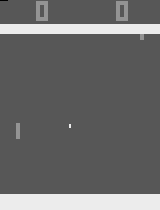

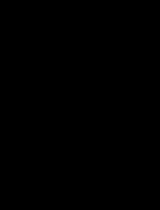

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
from PIL import Image
image = Image.fromarray(inputs[0][0].detach().numpy())# true value
image.show()

image = Image.fromarray(output[0][0].detach().numpy())# predicted value
image.show()
print(output[0][0].detach().numpy())

In [ ]:
gif = []
images = [Image.fromarray(observation) for observation in observations]
for image in images:
    gif.append(image)
gif[0].save('temp/result.gif', save_all=True,optimize=False, append_images=gif[1:], loop=0)

NameError: name 'observations' is not defined